<h2>Run decision tree</h2>

In [1]:
# Import packages
# General
import pandas as pd
import numpy as np
# Data visualisation  
import matplotlib.pyplot as plt   
import seaborn as sns
# For modeling
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from math import sqrt 
from sklearn.tree import DecisionTreeRegressor 
# For dates
from datetime import datetime as dt
from datetime import timedelta
# For holidays
import holidays
import pickle
# Import stuff for modeling
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Set modeling parametes
# old station_list  = ['3010', '3021', '3054', '3023', '3045']
station_list =  list(pickle.load(open("repeating_stations.pckl","rb")))

# Get a list of inactive stations. Eliminate them from the list
stations_df = pd.read_csv('data/indego-stations-2019-01-04.csv').reset_index()
inactive_list = stations_df[stations_df['Status'] == 'Inactive']['Station ID'].values.tolist()

year_range = [2016, 2017, 2018]
predict = 'count'
r_end = 'start'
training_end_date = "15/05/2018"
test_start_date = "01/07/2018"
start_features = ['temperature', 'humidity', 'precipIntensity', 'windBearing', 'windSpeed',  'snow', 'rain', 
                  'is_weekday_corrected', 'midday', 'night', 'rushE', 'rushM'] 

In [3]:
def get_train_test_data(which_station, year_range, training_end_date, test_start_date, start_features, predict, r_end):
    print('Station %s:' %which_station)
    # Aggregate data across years
    for item in year_range: 
        filename = 'intermediate_df/Full' + r_end + 'Station' + which_station + '-' + str(item) + '.csv'
        if item == year_range[0]:
            main_df = pd.read_csv(filename)
        else: 
            temp_df = pd.read_csv(filename)
            main_df = main_df.append(temp_df)     
    # Split
    training_end_date = dt.strptime(training_end_date, "%d/%m/%Y")
    test_start_date = dt.strptime(test_start_date, "%d/%m/%Y")
    training_df  = main_df[pd.to_datetime(main_df['date_time']) <= training_end_date].reset_index()
    test_df  = main_df[pd.to_datetime(main_df['date_time']) >= test_start_date].reset_index()
    test_df.head()
    X_train = training_df[start_features] #'which_holiday', 
    y_train = training_df[[predict]]
    X_test = test_df[start_features]
    y_test = test_df[[predict]]
    return X_train, y_train, X_test, y_test
                                                           
def fit_model_to_station(X_train, y_train, X_test, y_test, max_depth_range, print_results): 
    model_type = DecisionTreeRegressor(random_state = 0)
    param_grid = dict(max_depth = max_depth_range)
    time_series_cv = TimeSeriesSplit(n_splits = 3).split(X_train)
    grid_search = GridSearchCV(model_type, param_grid, n_jobs = -1, cv = time_series_cv, verbose = 0, scoring = 'neg_mean_absolute_error')
    grid_result = grid_search.fit(X_train, y_train)
    model = DecisionTreeRegressor(max_depth = grid_result.best_params_['max_depth']).fit(X_train, y_train)
    model = model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    predictions = predictions.round()
    
    # Baseline model
    baseline_model = round(y_test['count'].mean())
    baseline_model_pred = np.full_like(y_test.round(), baseline_model)
            
    if print_results: 
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
        print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

        # Print some diagnostics
        print('  Model diagnostics: ')
        print('\tMSE: %0.2f' %np.sqrt(metrics.mean_squared_error(y_test, predictions)))
        print('\tRMSE: %0.2f' %metrics.mean_squared_error(y_test, predictions))
        print('\tR^2:  %0.2f' %metrics.r2_score(y_test, predictions))
        
        # Print diagnostics on baseline
        print('  Baseline model:')
        print('\tMSE: %0.2f' %metrics.mean_squared_error(y_test, baseline_model_pred))
        print('\tRMSE: %0.2f' %np.sqrt(metrics.mean_squared_error(y_test, baseline_model_pred)))
        print('\tR^2: %0.2f' %metrics.r2_score(y_test, baseline_model_pred))
    return model, predictions, baseline_model_pred

In [4]:
max_depth_range = range(1, 15, 2)
pickle_it  = True 
print_results = True
criterion = 0
correct_model = []
correct_baseline = []
numbers_train = []
numbers_test = []
station_name = []
station_number = []
# Get a list of inactive stations. Eliminate them from the list
stations_df = pd.read_csv('data/indego-stations-2019-01-04.csv').reset_index()
inactive_list = stations_df[stations_df['Status'] == 'Inactive']['Station ID'].values.tolist()

for which_station in station_list: 
    which_station = str(which_station)
    which_station = which_station[:-2]
    # check that the station is active and only run the model if it is
    if int(which_station) not in inactive_list: 
        X_train, y_train, X_test, y_test = get_train_test_data(which_station, year_range, 
                                training_end_date, test_start_date, start_features, predict, r_end)
        model, predictions, baseline_pred = fit_model_to_station(X_train, y_train, X_test, y_test, 
                   max_depth_range, print_results)
        # Pickle model
        if pickle_it: 
            pickled_model_name = r_end + '_dt_model' + which_station + '.pckl'
            f = open(pickled_model_name, 'wb')
            pickle.dump(model, f)
            f.close()    
        # load each model, then estimate accuracy
        y_test_df = y_test
        y_test_df['model_pred'] = predictions
        y_test['model_dev'] = y_test_df['count']-y_test_df['model_pred']
        y_test['model_correct'] = y_test['model_dev'] <= np.absolute(criterion)

        y_test_df['baseline_pred'] = baseline_pred
        y_test['baseline_dev'] = y_test_df['count']-y_test_df['baseline_pred']
        y_test['baseline_correct'] = y_test['baseline_dev'] <= np.absolute(criterion)
        percent_correct_model = y_test['model_correct'].sum()/len(y_test)
        percent_correct_baseline = y_test['baseline_correct'].sum()/len(y_test)
        correct_model.append(percent_correct_model)
        correct_baseline.append(percent_correct_baseline)
        numbers_train.append(sum(y_train['count']))
        numbers_test.append(sum(y_test['count']))
        
        station_number.append(which_station)
        station_name.append(stations_df[stations_df['Station ID'] == int(which_station)]['Station Name'].values[0])
        
        print((sum(y_train['count']), sum(y_test['count'])))
        print('\tModel is correct %d%% time' %(percent_correct_model*100))
        print('\tBaseline is correct %d%% time' %(percent_correct_baseline*100))

Station 3072:
Best: -0.514915 using {'max_depth': 5}
Accuracy on training set: 0.216
Accuracy on test set: 0.233
  Model diagnostics: 
	MSE: 0.95
	RMSE: 0.89
	R^2:  0.17
  Baseline model:
	MSE: 1.22
	RMSE: 1.10
	R^2: -0.14
(9732, 1332)
	Model is correct 83% time
	Baseline is correct 85% time
Station 3073:
Best: -0.604478 using {'max_depth': 7}
Accuracy on training set: 0.229
Accuracy on test set: 0.152
  Model diagnostics: 
	MSE: 1.02
	RMSE: 1.04
	R^2:  0.08
  Baseline model:
	MSE: 1.20
	RMSE: 1.10
	R^2: -0.06
(11556, 1623)
	Model is correct 82% time
	Baseline is correct 79% time
Station 3074:
Best: -0.556330 using {'max_depth': 7}
Accuracy on training set: 0.272
Accuracy on test set: 0.009
  Model diagnostics: 
	MSE: 0.92
	RMSE: 0.85
	R^2:  -0.05
  Baseline model:
	MSE: 1.03
	RMSE: 1.02
	R^2: -0.28
(11127, 1034)
	Model is correct 88% time
	Baseline is correct 70% time
Station 3075:
Best: -0.590923 using {'max_depth': 7}
Accuracy on training set: 0.248
Accuracy on test set: 0.127
  Mod

Best: -0.106496 using {'max_depth': 7}
Accuracy on training set: 0.088
Accuracy on test set: -0.170
  Model diagnostics: 
	MSE: 0.35
	RMSE: 0.12
	R^2:  -0.24
  Baseline model:
	MSE: 0.11
	RMSE: 0.33
	R^2: -0.07
(1275, 182)
	Model is correct 92% time
	Baseline is correct 92% time
Station 3118:
Best: -0.315510 using {'max_depth': 9}
Accuracy on training set: 0.197
Accuracy on test set: 0.001
  Model diagnostics: 
	MSE: 0.76
	RMSE: 0.58
	R^2:  -0.19
  Baseline model:
	MSE: 0.62
	RMSE: 0.79
	R^2: -0.28
(4492, 799)
	Model is correct 78% time
	Baseline is correct 72% time
Station 3119:
Best: -0.236896 using {'max_depth': 7}
Accuracy on training set: 0.118
Accuracy on test set: -0.031
  Model diagnostics: 
	MSE: 0.64
	RMSE: 0.41
	R^2:  -0.30
  Baseline model:
	MSE: 0.39
	RMSE: 0.63
	R^2: -0.23
(3345, 587)
	Model is correct 78% time
	Baseline is correct 78% time
Station 3120:
Best: -0.532869 using {'max_depth': 5}
Accuracy on training set: 0.210
Accuracy on test set: 0.236
  Model diagnostics:

Best: -1.125018 using {'max_depth': 7}
Accuracy on training set: 0.504
Accuracy on test set: 0.086
  Model diagnostics: 
	MSE: 1.84
	RMSE: 3.38
	R^2:  0.05
  Baseline model:
	MSE: 3.71
	RMSE: 1.93
	R^2: -0.04
(31619, 3006)
	Model is correct 83% time
	Baseline is correct 66% time
Station 3024:
Best: -0.555986 using {'max_depth': 7}
Accuracy on training set: 0.245
Accuracy on test set: -0.040
  Model diagnostics: 
	MSE: 0.94
	RMSE: 0.88
	R^2:  -0.15
  Baseline model:
	MSE: 0.98
	RMSE: 0.99
	R^2: -0.27
(10207, 993)
	Model is correct 89% time
	Baseline is correct 70% time
Station 3025:
Best: -0.654874 using {'max_depth': 5}
Accuracy on training set: 0.262
Accuracy on test set: 0.148
  Model diagnostics: 
	MSE: 1.05
	RMSE: 1.10
	R^2:  0.13
  Baseline model:
	MSE: 1.30
	RMSE: 1.14
	R^2: -0.03
(14024, 1770)
	Model is correct 78% time
	Baseline is correct 79% time
Station 3026:
Best: -0.798666 using {'max_depth': 5}
Accuracy on training set: 0.245
Accuracy on test set: 0.038
  Model diagnostic

Best: -1.129360 using {'max_depth': 7}
Accuracy on training set: 0.342
Accuracy on test set: 0.262
  Model diagnostics: 
	MSE: 2.01
	RMSE: 4.03
	R^2:  0.27
  Baseline model:
	MSE: 5.53
	RMSE: 2.35
	R^2: -0.00
(28367, 4378)
	Model is correct 71% time
	Baseline is correct 66% time
Station 3055:
Best: -0.642586 using {'max_depth': 5}
Accuracy on training set: 0.326
Accuracy on test set: 0.306
  Model diagnostics: 
	MSE: 1.23
	RMSE: 1.51
	R^2:  0.27
  Baseline model:
	MSE: 2.10
	RMSE: 1.45
	R^2: -0.01
(13476, 1855)
	Model is correct 75% time
	Baseline is correct 79% time
Station 3056:
Best: -0.777722 using {'max_depth': 5}
Accuracy on training set: 0.264
Accuracy on test set: 0.062
  Model diagnostics: 
	MSE: 1.41
	RMSE: 1.98
	R^2:  -0.03
  Baseline model:
	MSE: 1.96
	RMSE: 1.40
	R^2: -0.01
(16991, 1813)
	Model is correct 82% time
	Baseline is correct 78% time
Station 3057:
Best: -1.233068 using {'max_depth': 7}
Accuracy on training set: 0.462
Accuracy on test set: 0.353
  Model diagnostic

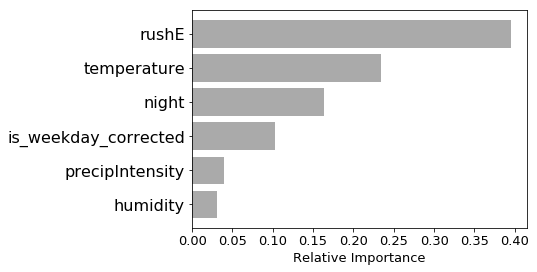

In [5]:
# load one model and plot feature importance
which_station = 3010
filename  = r_end + '_dt_model' + str(which_station) + '.pckl'
dt_model = pickle.load(open(filename, 'rb'))
features = start_features
importances = dt_model.feature_importances_
indices = np.argsort(importances)
how_many_feat = len(dt_model.feature_importances_[dt_model.feature_importances_>0.03])
plt.figure(1)
plt.barh(range(how_many_feat)[::-1], importances[indices][::-1][0:how_many_feat], color = (170/255, 170/255, 170/255))
plt.yticks(range(how_many_feat)[::-1], np.array(features)[indices][::-1][0:how_many_feat], fontsize=16)
plt.xlabel('Relative Importance',fontsize = 13)
plt.xticks(fontsize = 13)
plt.savefig("feature_importance.pdf", bbox_inches = 'tight')   

In [6]:
sum(np.subtract(correct_model,correct_baseline)>0)/len(correct_model)

0.6862745098039216

In [7]:
# summarize the results across the stations. 
results = pd.DataFrame()

In [8]:
results['st_num'] = station_number
results['st_name'] = station_name
results['n_test'] = numbers_test
results['n_train'] = numbers_train
results['per_correct_model'] = correct_model
results['per_correct_baseline'] = correct_baseline
results['percent_test'] = np.divide(numbers_test,np.add(numbers_test,numbers_train))*100
results['equal'] = (results['per_correct_model'] == results['per_correct_baseline'])
results['difference'] = np.subtract(correct_model,correct_baseline)*100

results = results[results['st_name']!="Virtual Station"]


In [9]:
results.to_csv('ResultsStartRides.csv')

In [10]:
#identify stations with very sparse data
at_least_six_a_day = 92*6
sparse_df = results[(results.n_test) <= at_least_six_a_day]
not_sparse_df = results[(results.n_test) > at_least_six_a_day]

In [11]:
len(not_sparse_df[not_sparse_df.per_correct_model > not_sparse_df.per_correct_baseline])/len(not_sparse_df)

0.7209302325581395

In [ ]:
len(not_sparse_df[not_sparse_df.per_correct_model > not_sparse_df.per_correct_baseline])/len(not_sparse_df)

In [12]:
not_sparse_worse  = not_sparse_df[not_sparse_df.per_correct_model < not_sparse_df.per_correct_baseline]

In [ ]:
# plot histogram of the model vs. baseline for stations where the data is not sparse
not_sparse_df['per_correct_baseline'].plot.hist(10)
not_sparse_df['per_correct_model'].plot.hist(10)

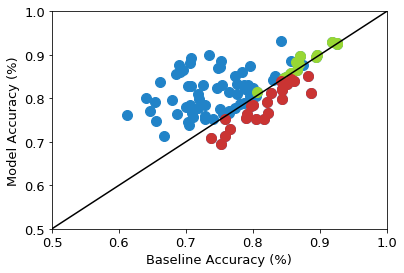

In [22]:
# Plot summary results (model vs. baseline)
plt.figure()
ax = plt.plot(results['per_correct_baseline'], results['per_correct_model'], 'o',
              color = (33/255, 131/255, 200/255), markersize = 10)
ax = plt.plot(sparse_df['per_correct_baseline'], sparse_df['per_correct_model'], 'o', markersize = 10, 
             color = '#98D734')
ax = plt.plot(not_sparse_worse['per_correct_baseline'], not_sparse_worse['per_correct_model'], 'o', markersize = 10, 
             color = '#CA3433')
plt.plot([0,1],[0,1], '-', color = 'k')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.xlabel('Baseline Accuracy (%)',fontsize = 13)
plt.ylabel('Model Accuracy (%)',fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.savefig("model_baseline_0.pdf", bbox_inches = 'tight')   